In [66]:
import scanpy as sc
import anndata
from anndata import read_h5ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import umap

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping

In this version, I tried normalizing all the data bore autoencoding it.
Problems arise with future use because we cannot give it new data that was not normalized together with the original healthy data it was trained on.

In [67]:
# Parameters
PCA_components = 70

In [68]:
# load the data
all_data = anndata.read_h5ad("all_data_10percent.h5ad")

# Normalizing all the data
sc.pp.normalize_total(all_data, target_sum=1e4)
sc.pp.log1p(all_data)

pca = PCA(n_components=PCA_components)

all_data.obsm["X_pca"] = pca.fit_transform(all_data.X)
all_data_normalized = all_data.obsm["X_pca"]

### --- Healthy cells --- ### 
healthy_cells = all_data_normalized[all_data.obs["disease"] == "normal"]
healthy = healthy_cells.copy()
X_train = healthy

In [69]:
# --- Building the Autoencoder ---
input_dim = X_train.shape[1]


# --- Define model ---
# Define the input layer - what dimension is the input?
input_layer = layers.Input(shape=(input_dim,))
# Define the architecture of the autoencoder
# Encoder
encoded = layers.Dense(64, activation='relu')(input_layer)
# Further encoding
encoded = layers.Dense(16, activation='relu')(encoded)
# Bottleneck
decoded = layers.Dense(64, activation='relu')(encoded)
# Decoder
decoded = layers.Dense(input_dim, activation='linear')(decoded)

# Create the autoencoder model
autoencoder = models.Model(input_layer, decoded)
#autoencoder.compile(optimizer='adam', loss=MeanAbsoluteError())
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=MeanAbsoluteError())
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_split=0.25,
    callbacks=[early_stop]  # optional
)

Epoch 1/50


2025-06-04 10:17:49.752889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-04 10:17:49.805858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


158/158 [==============================] - ETA: 0s - loss: 2.0744

2025-06-04 10:17:50.800960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - 2s 7ms/step - loss: 2.0744 - val_loss: 1.8357
Epoch 2/50
158/158 [==============================] - 1s 5ms/step - loss: 1.6935 - val_loss: 1.5818
Epoch 3/50
158/158 [==============================] - 1s 5ms/step - loss: 1.5025 - val_loss: 1.4330
Epoch 4/50
158/158 [==============================] - 1s 5ms/step - loss: 1.3734 - val_loss: 1.3169
Epoch 5/50
158/158 [==============================] - 1s 5ms/step - loss: 1.2755 - val_loss: 1.2335
Epoch 6/50
158/158 [==============================] - 1s 5ms/step - loss: 1.2004 - val_loss: 1.1669
Epoch 7/50
158/158 [==============================] - 1s 5ms/step - loss: 1.1415 - val_loss: 1.1181
Epoch 8/50
158/158 [==============================] - 1s 5ms/step - loss: 1.1001 - val_loss: 1.0841
Epoch 9/50
158/158 [==============================] - 1s 5ms/step - loss: 1.0700 - val_loss: 1.0568
Epoch 10/50
158/158 [==============================] - 1s 5ms/step - loss: 1.0447 - val_loss: 1.0332
Epoch 11/5

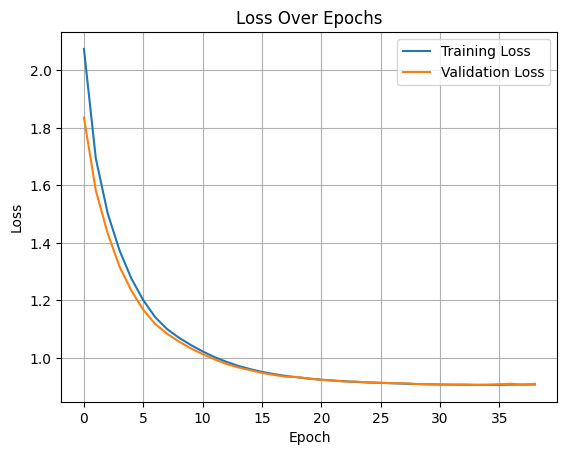

In [70]:


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
X_test = all_data_normalized
X_pred = autoencoder.predict(X_test)
errors = np.mean((X_test - X_pred) ** 2, axis=1)
print(X_test.shape, X_pred.shape, errors.shape)

# Add to AnnData for plotting
all_data.obs["reconstruction_error"] = errors

944/944 [==============================] - 2s 2ms/step
(30180, 70) (30180, 70) (30180,)


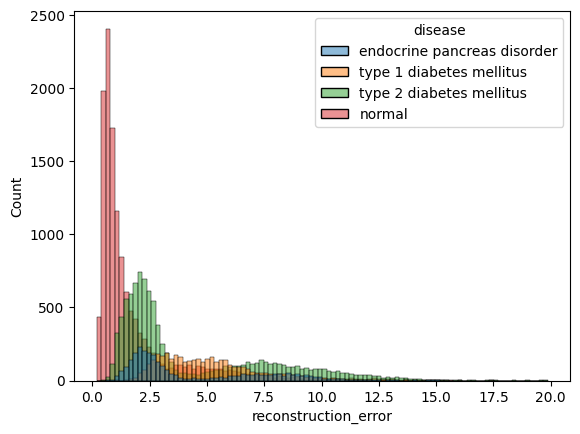

Distance between healthy and diseased cells:
Wasserstein distance: 2.435042829805516
KS statistic: 0.5471769400468256
p-value: 0.0
ROC AUC: 0.674798557889403


In [72]:
sns.histplot(data=all_data.obs, x="reconstruction_error", hue="disease", bins=100)
plt.show()

from scipy.stats import wasserstein_distance

print("Distance between healthy and diseased cells:")
group1 = all_data.obs[all_data.obs["disease"] == "normal"]["reconstruction_error"]
group2 = all_data.obs[all_data.obs["disease"] == "type 2 diabetes mellitus"]["reconstruction_error"]

distance = wasserstein_distance(group1, group2)
print("Wasserstein distance:", distance)

from scipy.stats import ks_2samp

ks_stat, ks_p = ks_2samp(group1, group2)
print("KS statistic:", ks_stat)
print("p-value:", ks_p)

from sklearn.metrics import roc_auc_score

labels = all_data.obs["disease"] == "type 2 diabetes mellitus"
scores = all_data.obs["reconstruction_error"]

auc = roc_auc_score(labels, scores)
print("ROC AUC:", auc)

160/944 [====>.........................] - ETA: 0s

2025-06-04 10:21:24.903674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


944/944 [==============================] - 1s 942us/step


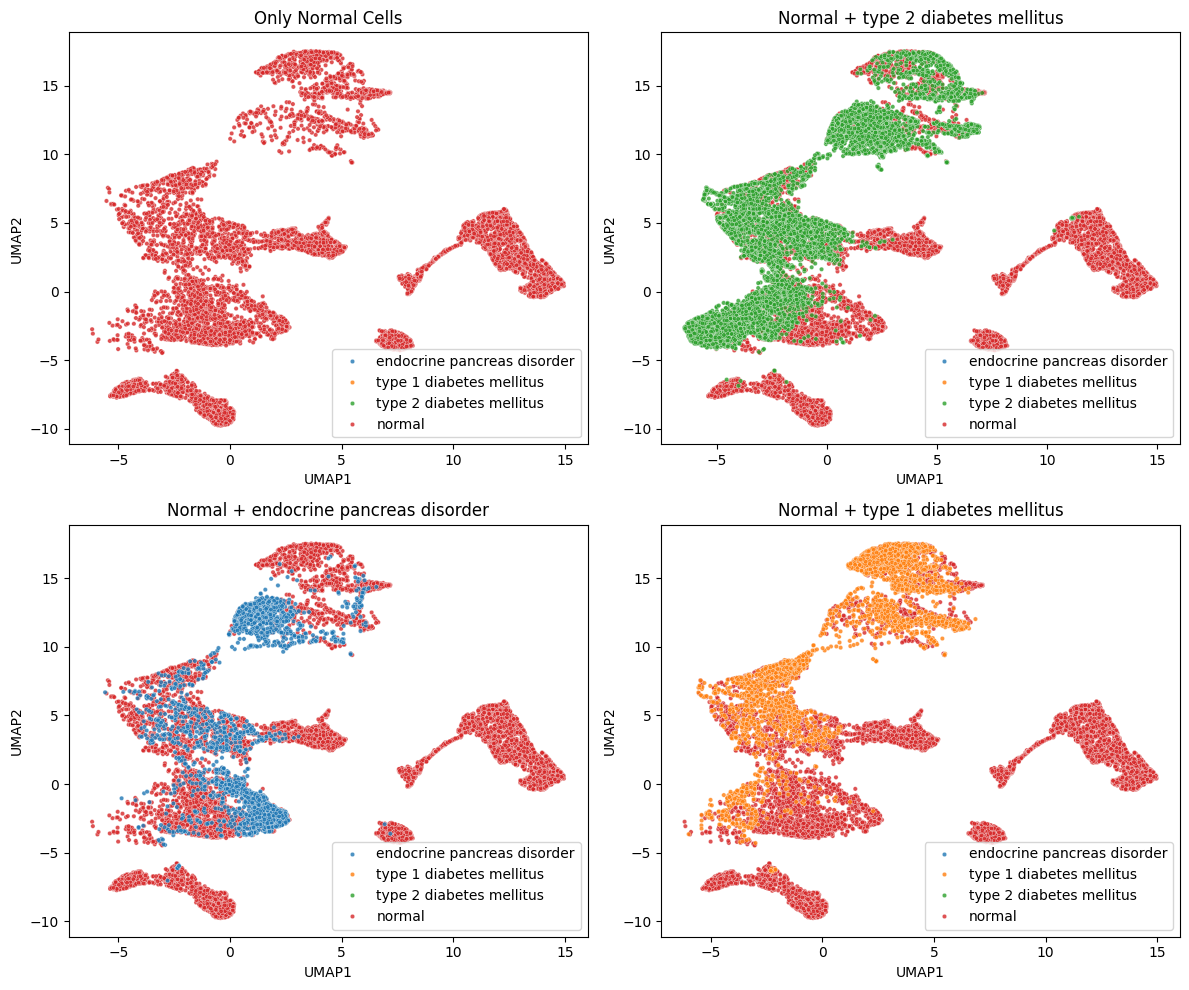

In [75]:
# Get the latent (encoded) space from the encoder
encoder = models.Model(inputs=input_layer, outputs=encoded)
X_encoded = encoder.predict(X_test)

# UMAP embedding
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
X_umap = reducer.fit_transform(X_encoded)

# Create DataFrame for plotting
df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df["disease"] = all_data.obs["disease"].values

# Find unique diseases
diseases = df["disease"].unique()
normal_df = df[df["disease"] == "normal"]
non_normal_diseases = [d for d in diseases if d != "normal"]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot 1: Normal only
sns.scatterplot(data=normal_df, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axes[0])
axes[0].set_title("Only Normal Cells")
axes[0].legend(loc="best")

# Plot 2–4: Normal + one disease
for i, disease in enumerate(non_normal_diseases[:3]):
    subset_df = pd.concat([normal_df, df[df["disease"] == disease]])
    sns.scatterplot(data=subset_df, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axes[i+1])
    axes[i+1].set_title(f"Normal + {disease}")
    axes[i+1].legend(loc="best")

plt.tight_layout()
plt.show()